In [92]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import rasterio.plot
import scipy.io as sio

# from mat73 import loadmat

In [33]:
data_path = '/nas/cee-water/cjgleason/data/Riggs_gauges/'

In [34]:
gauges = gpd.read_file(os.path.join(data_path, 'gauges.shp'))

In [35]:
gauges['lon'] = gauges.geometry.x
gauges['lat'] = gauges.geometry.y

In [36]:
gauges[(gauges['end'] == 2021) & (gauges['meanQ'] >= 300)]

,Sttn_Nm,start,end,obs,missed,meanQ,added,kge,rbias,rrmse,...,val,distance,model,node_id,continent,a,b,geometry,lon,lat
93,01034500_USGS,1902.0,2021.0,43457,0,345.960983,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,North America,NaN,NaN,POINT (-68.65139 45.23611),-68.651389,45.236111
583,01170500_USGS,1904.0,2021.0,42910,0,406.159086,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,North America,NaN,NaN,POINT (-72.5745 42.58022),-72.574500,42.580222
592,01172010_USGS,2002.0,2021.0,6932,0,471.797444,84.0,0.656364,16.203052,103.881429,...,45.0,-580.996603,Spl,73120000120761,North America,NaN,NaN,POINT (-72.60931 42.19147),-72.609311,42.191469
622,01184000_USGS,1928.0,2021.0,34021,0,489.391086,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,North America,NaN,NaN,POINT (-72.60537 41.98732),-72.605367,41.987319
929,01358000_USGS,1946.0,2021.0,26644,964,413.722645,26.0,0.709117,-0.114694,124.392616,...,88.0,-1616.782840,hg,73140300090071,North America,52.052820,0.330695,POINT (-73.68889 42.75222),-73.688889,42.752222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44744,86472000_ANA,2013.0,2021.0,2813,56,307.629462,263.0,0.456252,45.418711,106.328287,...,38.0,6947.827997,Pcw,64120200180271,South America,NaN,NaN,POINT (-51.6997 -29.0978),-51.699700,-29.097800
44747,86510000_ANA,1940.0,2021.0,29604,72,375.901432,14.0,0.483194,15.485025,106.556815,...,66.0,-587.539472,Spl,64120200150131,South America,NaN,NaN,POINT (-51.8686 -29.1672),-51.868600,-29.167200
44750,86720000_ANA,1941.0,2021.0,22473,6491,463.657157,137.0,0.427138,19.765282,203.744257,...,119.0,-1581.666009,hg,64120200140481,South America,70.775761,0.089185,POINT (-51.855 -29.2344),-51.855000,-29.234400
44775,87905000_ANA,1964.0,2021.0,20629,201,329.681844,42.0,0.853558,-0.199429,177.908326,...,98.0,1973.849020,Spl,64130000070471,South America,NaN,NaN,POINT (-52.0525 -31.0119),-52.052500,-31.011900


In [37]:
gauges['continent'].unique()

array(['Oceania', 'South America', 'North America', 'Asia', 'Europe',
       'Africa'], dtype=object)

In [72]:
gauges_sampled = gauges[(gauges['end'] >= 2015) & (gauges['meanQ'] >= 300)].groupby(by='continent').sample(n=2, random_state=0).reset_index()

In [11]:
# gauges_sampled = gauges[gauges['end'] >= 2000].gropsample(n=10, random_state=0)

<Axes: >

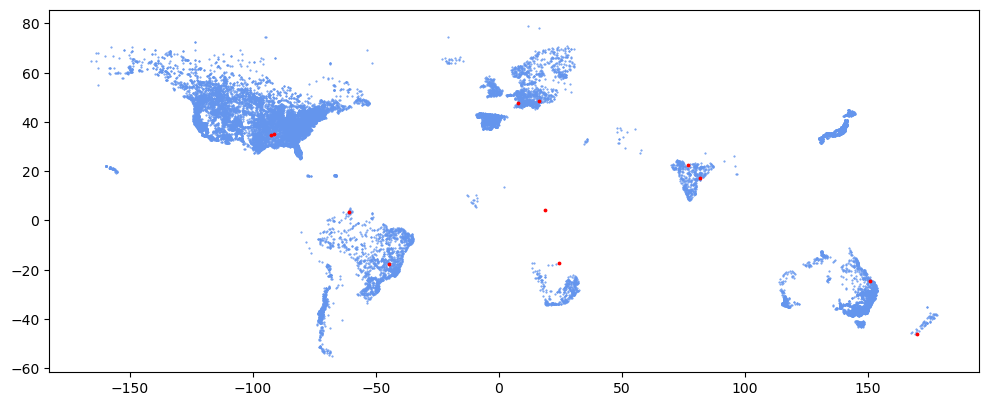

In [93]:
fig, ax = plt.subplots(figsize=(12,8))
gauges[gauges['end'] >= 2015].plot(markersize=0.25, ax=ax, color='cornflowerblue')
# gauges[(gauges['end'] >= 2000) & (gauges['meanQ'] >= 300)].plot(markersize=0.25, ax=ax, color='red')
# plt.xlim(-150, -50)
# plt.ylim(20, 60)
gauges_sampled.plot(markersize=3, ax=ax, color='red')

In [73]:
gauges_sampled = gauges_sampled[['Sttn_Nm', 'start', 'end', 'obs',
                                 'missed', 'continent', 'lon', 'lat',
                                 'geometry']]

In [75]:
gauges_sampled['lon_tile'] = (round((gauges_sampled['lon'] /  10), 0) * 10).astype(int)
gauges_sampled['lat_tile'] = (round((gauges_sampled['lat'] /  10), 0) * 10).astype(int)

In [76]:
def constructTileName(df):
    name = 'occurrence_'
    
    if df['lon'] < 0:
        name += (str(np.abs(df['lon_tile'])) + 'W_')
    else:
        name += (str(df['lon_tile']) + 'E_')
    
    if df['lat'] < 0:
        name += (str(np.abs(df['lat_tile'])) + 'Sv1_4_2021.tif')
        
    else:
        name += (str(df['lat_tile']) + 'Nv1_4_2021.tif' )
    
    return name

In [77]:
gauges_sampled['tile_name'] = gauges_sampled.apply(constructTileName, axis=1)

In [78]:
gauges_sampled

,Sttn_Nm,start,end,obs,missed,continent,lon,lat,geometry,lon_tile,lat_tile,tile_name
0,1749100_GRDC,1911.0,2016.0,32202,6451,Africa,18.583333,4.366667,POINT (18.58333 4.36667),20,0,occurrence_20E_0Nv1_4_2021.tif
1,1291100_GRDC,1942.0,2018.0,23954,3655,Africa,24.300000,-17.467000,POINT (24.3 -17.467),20,-20,occurrence_20E_20Sv1_4_2021.tif
2,1472_In_IWRIS,1977.0,2020.0,15236,623,Asia,76.993611,22.490278,POINT (76.99361 22.49028),80,20,occurrence_80E_20Nv1_4_2021.tif
3,1853_In_IWRIS,1965.0,2019.0,19226,230,Asia,81.659722,17.245833,POINT (81.65972 17.24583),80,20,occurrence_80E_20Nv1_4_2021.tif
4,6935051_GRDC,1869.0,2018.0,54786,0,Europe,7.616700,47.559400,POINT (7.6167 47.5594),10,50,occurrence_10E_50Nv1_4_2021.tif
5,6242501_GRDC,1996.0,2017.0,8036,0,Europe,16.343750,48.360416,POINT (16.34375 48.36042),20,50,occurrence_20E_50Nv1_4_2021.tif
6,07076750_USGS,1927.0,2021.0,11278,23048,North America,-91.449722,35.128889,POINT (-91.44972 35.12889),-90,40,occurrence_90W_40Nv1_4_2021.tif
7,07263450_USGS,2016.0,2020.0,1463,0,North America,-92.358333,34.793056,POINT (-92.35833 34.79306),-90,30,occurrence_90W_30Nv1_4_2021.tif
8,130379A_BOM,2017.0,2021.0,1380,7,Oceania,150.815630,-24.452572,POINT (150.81563 -24.45257),150,-20,occurrence_150E_20Sv1_4_2021.tif
9,5868100_GRDC,1954.0,2020.0,24265,19,Oceania,169.747983,-46.237280,POINT (169.74798 -46.23728),170,-50,occurrence_170E_50Sv1_4_2021.tif


In [79]:
tile_path = '/nas/cee-water/cjgleason/data/GSW/occurrence2021/'

In [108]:
# Assume you have a raster file 'your_raster.tif'
# and a dataframe 'your_points_df' with 'latitude' and 'longitude' columns

# Open the raster
rst = rasterio.open(os.path.join(tile_path, gauges_sampled.iloc[0]['tile_name']), 'r')
rst0 = rasterio.open(os.path.join(tile_path, 'occurrence_10E_10Nv1_4_2021.tif'), 'r')

In [103]:
rst.bounds

BoundingBox(left=20.0, bottom=-10.0, right=30.0, top=0.0)

In [109]:
rst0.bounds

BoundingBox(left=10.0, bottom=0.0, right=20.0, top=10.0)

In [ ]:
rasterio.plot.show(rst, cmap='Greys_r');

In [87]:
# with rasterio.open(os.path.join(tile_path, gauges_sampled.iloc[0]['tile_name'])) as src:
#             # Read a band from the raster
#             band1 = src.read(1)

In [101]:
gauges_sampled

,Sttn_Nm,start,end,obs,missed,continent,lon,lat,geometry,lon_tile,lat_tile,tile_name
0,1749100_GRDC,1911.0,2016.0,32202,6451,Africa,18.583333,4.366667,POINT (18.58333 4.36667),20,0,occurrence_20E_0Nv1_4_2021.tif
1,1291100_GRDC,1942.0,2018.0,23954,3655,Africa,24.300000,-17.467000,POINT (24.3 -17.467),20,-20,occurrence_20E_20Sv1_4_2021.tif
2,1472_In_IWRIS,1977.0,2020.0,15236,623,Asia,76.993611,22.490278,POINT (76.99361 22.49028),80,20,occurrence_80E_20Nv1_4_2021.tif
3,1853_In_IWRIS,1965.0,2019.0,19226,230,Asia,81.659722,17.245833,POINT (81.65972 17.24583),80,20,occurrence_80E_20Nv1_4_2021.tif
4,6935051_GRDC,1869.0,2018.0,54786,0,Europe,7.616700,47.559400,POINT (7.6167 47.5594),10,50,occurrence_10E_50Nv1_4_2021.tif
5,6242501_GRDC,1996.0,2017.0,8036,0,Europe,16.343750,48.360416,POINT (16.34375 48.36042),20,50,occurrence_20E_50Nv1_4_2021.tif
6,07076750_USGS,1927.0,2021.0,11278,23048,North America,-91.449722,35.128889,POINT (-91.44972 35.12889),-90,40,occurrence_90W_40Nv1_4_2021.tif
7,07263450_USGS,2016.0,2020.0,1463,0,North America,-92.358333,34.793056,POINT (-92.35833 34.79306),-90,30,occurrence_90W_30Nv1_4_2021.tif
8,130379A_BOM,2017.0,2021.0,1380,7,Oceania,150.815630,-24.452572,POINT (150.81563 -24.45257),150,-20,occurrence_150E_20Sv1_4_2021.tif
9,5868100_GRDC,1954.0,2020.0,24265,19,Oceania,169.747983,-46.237280,POINT (169.74798 -46.23728),170,-50,occurrence_170E_50Sv1_4_2021.tif


<Axes: >

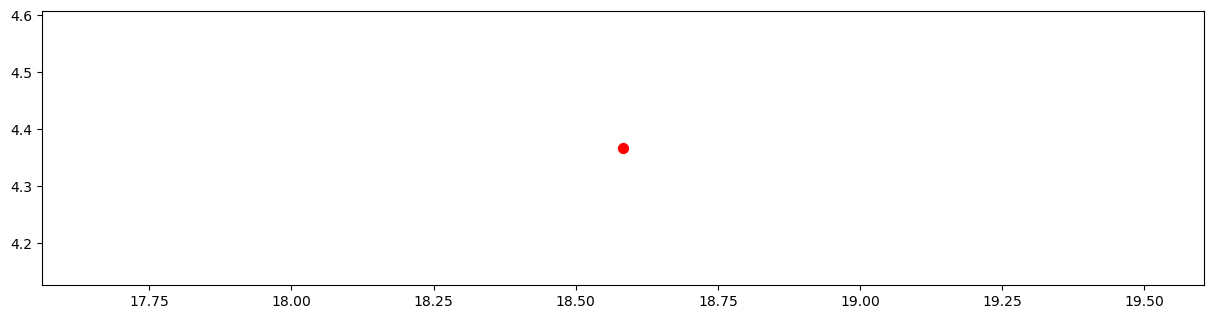

In [102]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the raster data
# rasterio.plot.show(rst, cmap='Greys_r');

# Plot the points on the same axis as the raster
gauges_sampled.iloc[[0]].plot(ax=ax, marker='o', color='red', markersize=50) # 

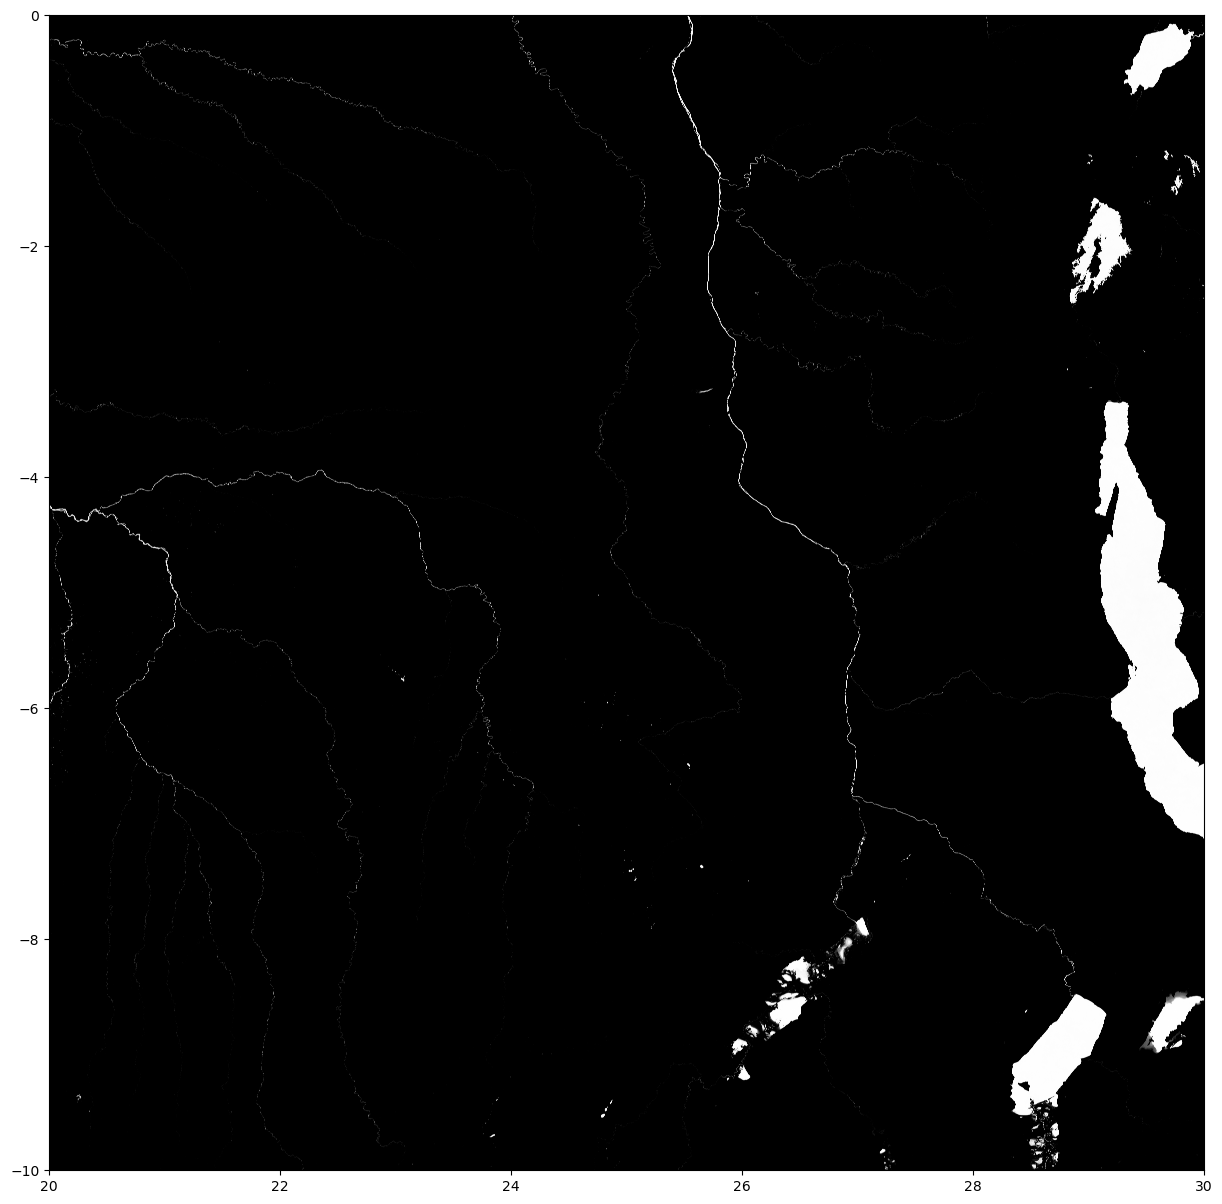

In [100]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the raster data
rasterio.plot.show(rst, cmap='Greys_r');

# Plot the points on the same axis as the raster
gauges_sampled.iloc[[0]].plot(ax=ax, marker='o', color='red', markersize=50) # Adjust colors and markers as needed

# Show the plot
plt.show()

In [96]:
save_path = '/nas/cee-water/cjgleason/fiona/MODIS_discharge/data'

In [97]:
gauges_sampled.to_parquet(os.path.join(save_path,
                                       'gauges_sampled.parquet'))

In [53]:
mat_data = sio.loadmat('/nas/cee-water/cjgleason/fiona/MODIS_discharge/data/gauges_sampled.mat')

In [57]:
mat_data['Sttn_Nm'][0][0]

array(['1196175_GRDC'], dtype='<U12')

In [22]:
def getFiles(filepath):
    files = []
    for file in os.listdir(data_path):
        if not file.startswith('.') and not file.endswith('.zip'):
            files.append(os.path.join(data_path, file))
    return files

In [98]:
def filterFiles(files, date):
    
    files_aqua = []
    
    for file in files:
        # read in
        df = pd.read_csv(file).reset_index()
        # set correct column names, drop row 0
        df.columns = df.iloc[0]
        df = df.iloc[1:]
        # make date object
        df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
        filtered = df[df['date'] >= date]
        
        if filtered.shape[0] != 0:
            files_aqua.append(file)
        
    return files_aqua

In [100]:
files = getFiles(data_path)

In [ ]:
files_aqua = filterFiles(files=files, date='2002-07-04')

In [55]:
test.columns = test.iloc[0]

In [57]:
test = test.iloc[1:]

In [67]:
test['date'] = pd.to_datetime(test[['Year', 'Month', 'Day']])

/tmp/ipykernel_3768475/3608695399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = pd.to_datetime(test[['Year', 'Month', 'Day']])


In [69]:
test[test['date'] >= '2002-07-04']

,Year,Month,Day,Discharge (m^3/s),date
8036,2005,6,3,0,2005-06-03
8037,2005,6,4,0,2005-06-04
8038,2005,6,5,0,2005-06-05
8039,2005,6,6,0,2005-06-06
8040,2005,6,7,0,2005-06-07
...,...,...,...,...,...
13972,2021,9,3,0,2021-09-03
13973,2021,9,4,0,2021-09-04
13974,2021,9,5,0,2021-09-05
13975,2021,9,6,0,2021-09-06


In [53]:
test.iloc[1:,0:3]

,index,Latitude: -22.910194,Longitude: 139.915972
1,1966,10,1
2,1966,10,2
3,1966,10,3
4,1966,10,4
5,1966,10,5
...,...,...,...
13972,2021,9,3
13973,2021,9,4
13974,2021,9,5
13975,2021,9,6


In [49]:
np.array(test['index'][1:].astype(int))

array([1966, 1966, 1966, ..., 2021, 2021, 2021])